# Data Challenge - Face Recognition
## Solved with neural network

The neural network will be implemented with Keras because its a simple framework. <br>
The input are the vectors making the images and the output will be the labels 1 and 0.

### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
import shap

np.random.seed(seed=42)

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

### Loading the data

In [3]:
def extract_labels(txt_file):
    with open(txt_file) as file:
        lines = file.readlines()
    y = []
    for elem in lines:
        label = int(elem[0])
        y.append(label)
    y = np.array(y)
    return y

In [4]:
X, y = np.load("train_data.npy"), extract_labels("train_labels.txt")

In [5]:
def criterion(y_pred, y_true):
    CM = confusion_matrix(y_true, y_pred)
    TN, TP = CM[0, 0], CM[1, 1]
    FP, FN = CM[0, 1], CM[1, 0]
    return FP/(FP + TN) + FN/(FN + TP)

### Features extraction

In [6]:
scaler = StandardScaler()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)

In [7]:
X_train.shape

(267508, 96)

### Defining the model

In [8]:
model = keras.Sequential([
    layers.InputLayer(input_shape=(96,)), # INPUT LAYER : 96 neurons; onne for each feature
    layers.Dense(500, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(500, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(500, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid") # OUTPUT LAYER : outputting the predicted labels
])

### Compiling the model

In [9]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
loss="binary_crossentropy",
metrics=["accuracy"])

### Training the model

In [10]:
history = model.fit(X_train, y_train, epochs=30, batch_size=512, validation_data=(X_valid, y_valid))

Epoch 1/30
523/523 [==============================] - 10s 19ms/step - loss: 0.5114 - accuracy: 0.7475 - val_loss: 0.4697 - val_accuracy: 0.7745
Epoch 2/30
523/523 [==============================] - 9s 18ms/step - loss: 0.4751 - accuracy: 0.7718 - val_loss: 0.4598 - val_accuracy: 0.7816
Epoch 3/30
523/523 [==============================] - 9s 18ms/step - loss: 0.4624 - accuracy: 0.7791 - val_loss: 0.4488 - val_accuracy: 0.7874
Epoch 4/30
523/523 [==============================] - 9s 18ms/step - loss: 0.4516 - accuracy: 0.7856 - val_loss: 0.4392 - val_accuracy: 0.7907
Epoch 5/30
523/523 [==============================] - 9s 18ms/step - loss: 0.4437 - accuracy: 0.7909 - val_loss: 0.4341 - val_accuracy: 0.7954
Epoch 6/30
523/523 [==============================] - 9s 17ms/step - loss: 0.4384 - accuracy: 0.7937 - val_loss: 0.4312 - val_accuracy: 0.7966
Epoch 7/30
523/523 [==============================] - 9s 18ms/step - loss: 0.4338 - accuracy: 0.7961 - val_loss: 0.4294 - val_accuracy: 0.797

Confusion Matrix: 
 [[12044  2818]
 [ 3026 11836]]
Accuracy: 0.803391199031086
False Positive Rate: 0.1896110886825461
False Negative Rate: 0.20360651325528192
FPR + FNR = 0.393217601937828
score =  0.606782398062172


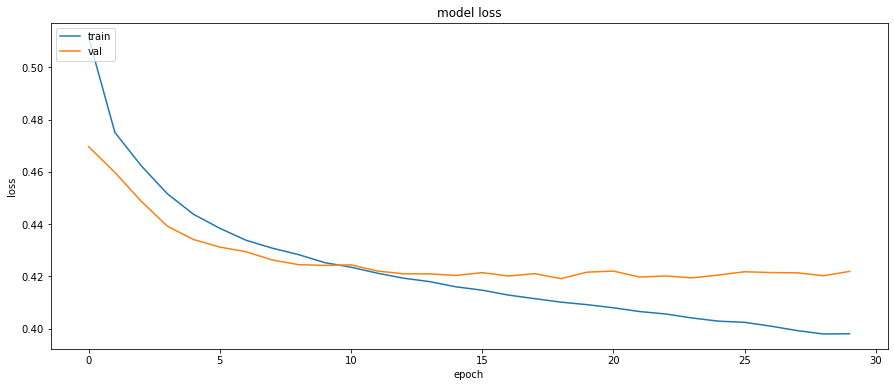

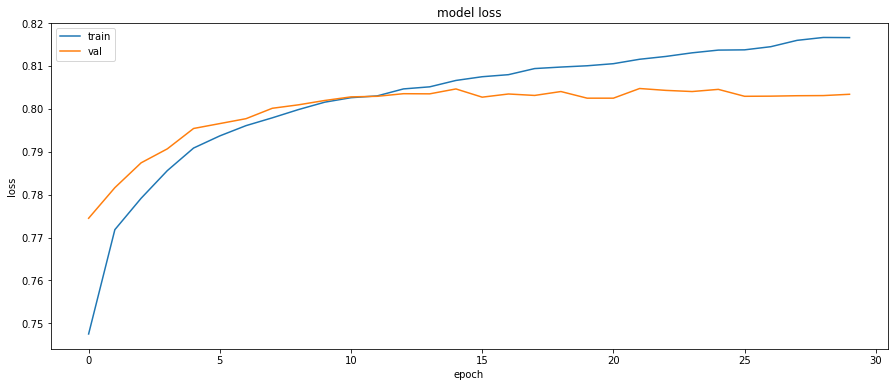

In [11]:
threshold = 0.5
y_pred = model.predict(X_valid)
for i in range(y_pred.shape[0]):
    if y_pred[i] > threshold:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

# to further inspect the performance:
CM = confusion_matrix(y_valid, y_pred)
TN, TP = CM[0, 0], CM[1, 1]
FP, FN = CM[0, 1], CM[1, 0]
print('Confusion Matrix: \n {}'.format(CM))
print('Accuracy: {}'.format((TP + TN) / (TP + TN + FP + FN)))  
print('False Positive Rate: {}'.format(FP / (FP + TN)))  
print('False Negative Rate: {}'.format(FN / (FN + TP)))
print('FPR + FNR = {}'.format(FP / (FP + TN) + FN / (FN + TP)))

print("score = ", 1 - (FP / (FP + TN) + FN / (FN + TP)))

plt.figure(figsize=(15,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(15,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
# Load test data
X_test = np.load("test_data.npy")
X_test = scaler.fit_transform(X_test)
# Classify the provided test data
y_test = list()
y_pred = model.predict(X_test)
for i in range(y_pred.shape[0]):
    if y_pred[i] > threshold:
        #y_test[i] = 1
        y_test.append(1)
    else:
        #y_test[i] = 0
        y_test.append(0)
#y_test = y_test.astype(np.int8)
y_test = np.array(y_test)
np.savetxt('y_test_challenge_student.txt', y_test, fmt='%i' , delimiter=',')

In [13]:
y_test

array([1, 0, 1, ..., 0, 1, 0])

###  Feature Importance
#### SHapley Additive exPlanation - SHAP

This library allow to compute the shapley value of each features : we will see the contribution of each features in the neural network model that gives the output prediction. <br>
By identifying the important features, we can throw away features that doesn't contribute the prediction, thus, the model will run faster as there are fewer features to take into account. We will also see if the score will increase once we take only the important features in the neural network.

TreeExplainer is for Machine Learning models such as XGBoost, CatBoost or LightGMB. <br>
Here, we are going to use DeepExplainer (DEEP SHAP) which support Tensorflow and Keras models.

#### DeepExplainer use

In [14]:
explainer = shap.DeepExplainer(model, X_train[:1000])
shap_values = explainer.shap_values(X_valid[:1000])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [15]:
y_preds = model.predict(X_valid)

In [16]:
clust = shap.utils.hclust(X_valid, y_valid, linkage="single")

 49%|████████████████████████████████████████▏                                         | 47/96 [02:50<02:52,  3.52s/it]No/low signal found from feature 46 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
97it [06:22,  4.07s/it]                                                                                                


In [17]:
shap.initjs()
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(X_valid)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


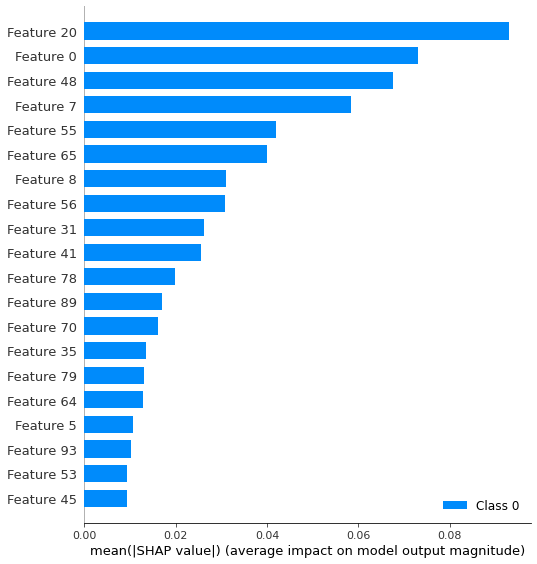

In [18]:
shap.summary_plot(shap_values, X_train, plot_type="bar")
plt.show()

We obtained the following import features, now we will rerun the model only with these features.

In [19]:
X_new = X[:,[20, 0, 48, 7, 55, 65, 56, 31, 8, 41, 78, 70, 89, 79, 35, 93, 5, 45, 64, 30]]

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X_new, y, test_size=0.1)

X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)

In [21]:
model1 = keras.Sequential([
    layers.InputLayer(input_shape=(20,)), # INPUT LAYER : 96 neurons; onne for each feature
    layers.Dense(600, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(600, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(1, activation="sigmoid") # OUTPUT LAYER : outputting the predicted labels
])

In [22]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model1.compile(optimizer=opt,
loss="binary_crossentropy",
metrics=["accuracy"])

In [23]:
history = model1.fit(X_train, y_train, epochs=100, batch_size=512, validation_data=(X_valid, y_valid))

Epoch 1/100
523/523 [==============================] - 9s 16ms/step - loss: 0.5117 - accuracy: 0.7477 - val_loss: 0.4662 - val_accuracy: 0.7782
Epoch 2/100
523/523 [==============================] - 9s 17ms/step - loss: 0.4781 - accuracy: 0.7702 - val_loss: 0.4526 - val_accuracy: 0.7840
Epoch 3/100
523/523 [==============================] - 10s 19ms/step - loss: 0.4681 - accuracy: 0.7764 - val_loss: 0.4469 - val_accuracy: 0.7872
Epoch 4/100
523/523 [==============================] - 10s 18ms/step - loss: 0.4623 - accuracy: 0.7809 - val_loss: 0.4433 - val_accuracy: 0.7903
Epoch 5/100
523/523 [==============================] - 9s 17ms/step - loss: 0.4585 - accuracy: 0.7825 - val_loss: 0.4410 - val_accuracy: 0.7904
Epoch 6/100
523/523 [==============================] - 9s 16ms/step - loss: 0.4552 - accuracy: 0.7845 - val_loss: 0.4396 - val_accuracy: 0.7912
Epoch 7/100
523/523 [==============================] - 9s 17ms/step - loss: 0.4532 - accuracy: 0.7855 - val_loss: 0.4382 - val_accurac

Confusion Matrix: 
 [[12236  2591]
 [ 3426 11471]]
Accuracy: 0.7975709864082896
False Positive Rate: 0.1747487691373845
False Negative Rate: 0.2299791904410284
FPR + FNR = 0.4047279595784129
score =  0.5952720404215871


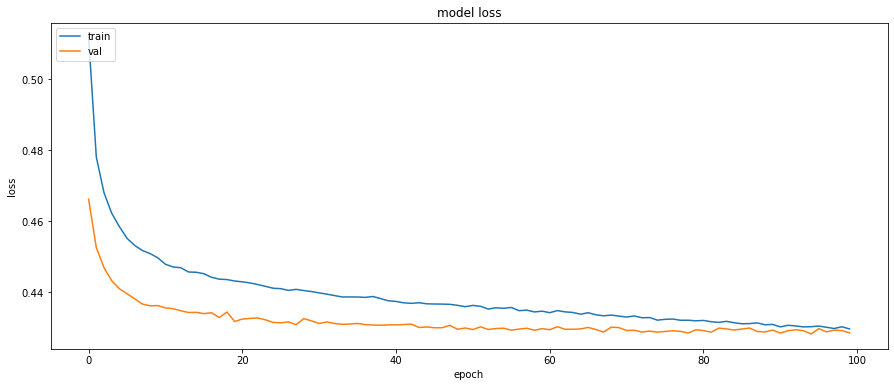

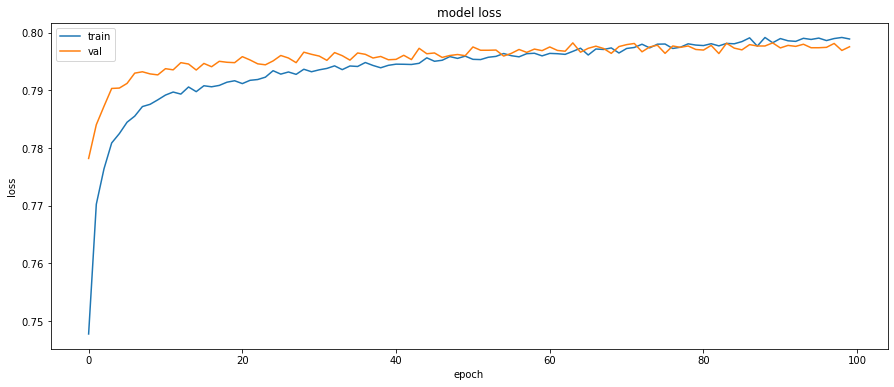

In [24]:
threshold = 0.5
y_pred = model1.predict(X_valid)
for i in range(y_pred.shape[0]):
    if y_pred[i] > threshold:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

# to further inspect the performance:
CM = confusion_matrix(y_valid, y_pred)
TN, TP = CM[0, 0], CM[1, 1]
FP, FN = CM[0, 1], CM[1, 0]
print('Confusion Matrix: \n {}'.format(CM))
print('Accuracy: {}'.format((TP + TN) / (TP + TN + FP + FN)))  
print('False Positive Rate: {}'.format(FP / (FP + TN)))  
print('False Negative Rate: {}'.format(FN / (FN + TP)))
print('FPR + FNR = {}'.format(FP / (FP + TN) + FN / (FN + TP)))

print("score = ", 1 - (FP / (FP + TN) + FN / (FN + TP)))

plt.figure(figsize=(15,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(15,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
# Load test data
X_test = np.load("test_data.npy")
X_test = scaler.fit_transform(X_test)
# Classify the provided test data
y_test = list()
y_pred = model.predict(X_test)
for i in range(y_pred.shape[0]):
    if y_pred[i] > threshold:
        #y_test[i] = 1
        y_test.append(1)
    else:
        #y_test[i] = 0
        y_test.append(0)
#y_test = y_test.astype(np.int8)
y_test = np.array(y_test)
np.savetxt('y_test_challenge_student.txt', y_test, fmt='%i' , delimiter=',')

In [26]:
y_test

array([1, 0, 1, ..., 0, 1, 0])